Using FIPS code '09' for input 'CT'


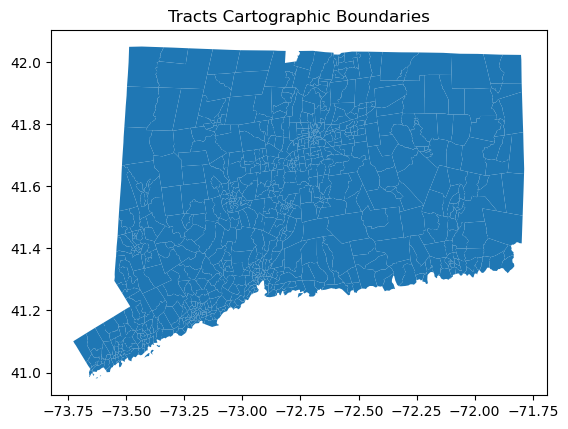

In [82]:
import pygris
from pygris import tracts
from matplotlib import pyplot as plt
import pandas as pd
import folium
import numpy as np
import geopandas as gp
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import libpysal as lp
from scipy.stats import linregress
import rasterio
from rasterstats import zonal_stats


# Download geometry
ct_tracts = tracts(state = "CT", cb = True, cache = True, year = 2016)

# Display geometry
fig, ax = plt.subplots()
ct_tracts.plot(ax = ax)
plt.title("Tracts Cartographic Boundaries");

# Import tracts population data
pop = pd.read_csv("../data/population.csv")

# Convert data type so join key matches
ct_tracts["Geo_TRACT"] = ct_tracts["TRACTCE"].astype(int)

# Join attributes to geometry
tracts = ct_tracts.merge(pop, how = "inner", on='Geo_TRACT')

# Project tracts
tracts = tracts.to_crs("EPSG:3857")

# Calculate area in KM
tracts["Area"] = tracts.area/1000**2

# Calculate population density
tracts["PopDensity"] = tracts["SE_A00001_001"]/tracts["Area"]



In [83]:
# #import raster
# raster_path = 'ct_2016_ccap_hires_landcover_20200915.tif'
# landcover = rasterio.open(raster_path)
# arr = landcover.read(1)
# affine = landcover.transform

# zone = tracts.to_crs(landcover.crs)

In [84]:
# df_new = zonal_stats(zone, arr, affine=affine, categorical = True)

In [85]:
# df_categorical = pd.DataFrame(df_new)

# df_categorical['max_type'] = df_categorical.idxmax(axis=1)
# combined_df = pd.concat([tracts, df_categorical], axis=1)
# combined_df['max_type'] = combined_df['max_type'].astype(str)

# # save zonal stat to combined_data.csv
# combined_df.to_csv('combined_data.csv', index=False)

In [86]:
data = pd.read_csv("../data/combined_data.csv")
data[pd.isnull(data.iloc[:,68:-1])] = 0

X = data.iloc[:,68:-2]
y = data["PopDensity"]


In [87]:
gdf = gp.read_file('../data/tl_2016_09_tract.shp')

In [88]:
data
# 'GEOID' to str
gdf['TRACTCE'] = gdf['TRACTCE'].astype(int)
data['TRACTCE'] = data['TRACTCE'].astype(int)

In [89]:
# merge csv with shapfile using TRACTCE
merged_gdf = gdf.merge(data, on='TRACTCE', how='left')


In [90]:
# make merged_gdf into geo dataframe
merged_gdf = gp.GeoDataFrame(merged_gdf)

# drop out all rows that have no population density
merged_gdf = merged_gdf.dropna(subset=['PopDensity'], axis=0)
merged_gdf = merged_gdf[merged_gdf['PopDensity'] != 0]
merged_gdf = merged_gdf[merged_gdf['TRACTCE'] != 194202]

# define the geometry_x column to be the geometry feature 
merged_gdf.set_geometry("geometry_x", inplace=True)

# calculate Queen's neighbor weights for each tracts
w = lp.weights.Queen.from_dataframe(merged_gdf)
w.transform = 'R'

/tmp/ipykernel_205227/2718179735.py:13: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = lp.weights.Queen.from_dataframe(merged_gdf)


In [91]:
# compute spatial lag of population density
merged_gdf['spatial_lag_PopDens'] = lp.weights.lag_spatial(w, merged_gdf['PopDensity'])

# calculate the mean pop density of each tract's neighbors
#merged_gdf['avg_neighbor_density'] = merged_gdf.groupby('TRACTCE')['spatial_lag'].transform('mean')
merged_gdf['PopDensity'] = merged_gdf['PopDensity'].astype(float)

# download merged_gdf to csv file
merged_gdf.to_csv('../data/merged_gdf.csv', index=False)

Spatial autocorrelation evaluation - Showcase

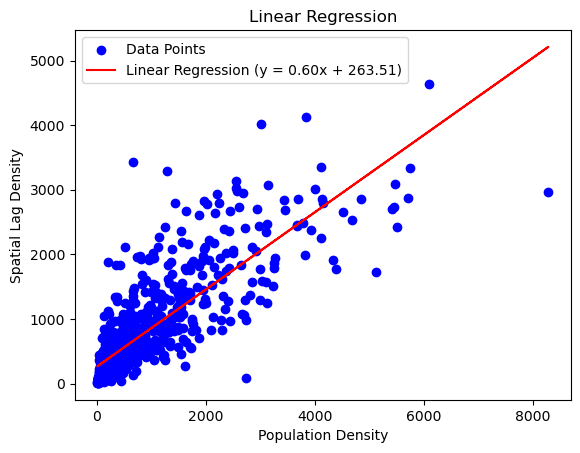

In [92]:
from sklearn.linear_model import LinearRegression

merged_csv_moran = pd.read_csv("../data/merged_gdf.csv", usecols=['PopDensity', 'spatial_lag_PopDens', "Geo_NAME"]).dropna()

# Extract x and y columns from the DataFrame
x = merged_csv_moran['PopDensity'].values.reshape(-1, 1)  # Reshape to make it a 2D array for scikit-learn
y = merged_csv_moran['spatial_lag_PopDens'].values

# Create a scatter plot of x vs y
plt.scatter(x, y, color='blue', label='Data Points')

# Fit a linear regression model
model = LinearRegression()
model.fit(x, y)

# Get the slope and intercept of the fitted line
slope = model.coef_[0]
intercept = model.intercept_

# Plot the fitted line
plt.plot(x, model.predict(x), color='red', label=f'Linear Regression (y = {slope:.2f}x + {intercept:.2f})')

# Add labels and title
plt.xlabel('Population Density')
plt.ylabel('Spatial Lag Density')
plt.title('Linear Regression')
plt.legend()

# Show plot
plt.show()


/tmp/ipykernel_205227/3138805767.py:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'High-High' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  merged_gdf.loc[(merged_gdf['spatial_lag_PopDens'] >= p) & (merged_gdf['PopDensity'] >= q), 'category'] = 'High-High'


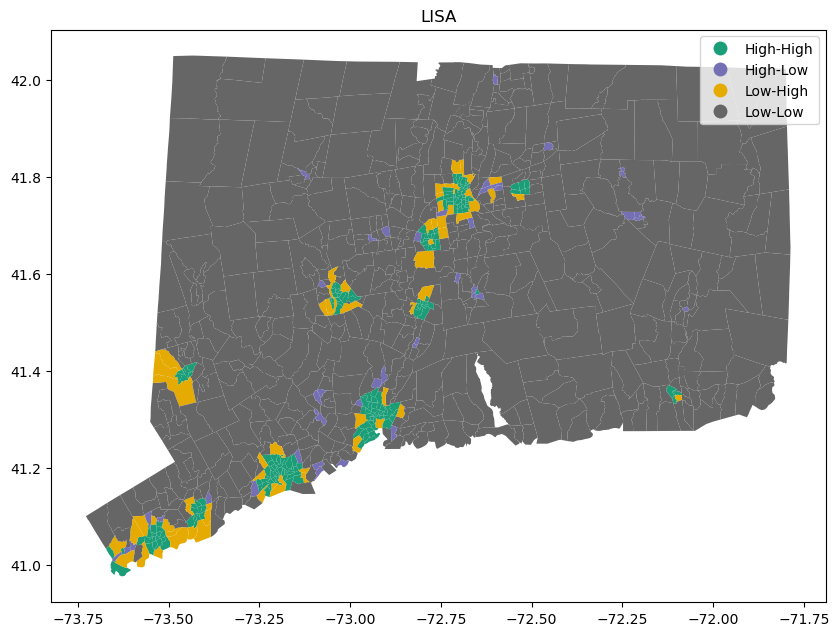

In [93]:
# Calculate the average for 'spatial_lag_PopDens' and 'PopDensity'
p = merged_gdf['spatial_lag_PopDens'].mean()
q = merged_gdf['PopDensity'].mean()

# Categorize the rows based on conditions
merged_gdf['category'] = 0  # Initialize category column
merged_gdf.loc[(merged_gdf['spatial_lag_PopDens'] >= p) & (merged_gdf['PopDensity'] >= q), 'category'] = 'High-High'
merged_gdf.loc[(merged_gdf['spatial_lag_PopDens'] >= p) & (merged_gdf['PopDensity'] < q), 'category'] = 'Low-High'
merged_gdf.loc[(merged_gdf['spatial_lag_PopDens'] < p) & (merged_gdf['PopDensity'] >= q), 'category'] = 'High-Low'
merged_gdf.loc[(merged_gdf['spatial_lag_PopDens'] < p) & (merged_gdf['PopDensity'] < q), 'category'] = 'Low-Low'

# Plot the map
fig, ax = plt.subplots(figsize=(10, 10))
merged_gdf.plot(column='category', cmap='Dark2', legend=True, ax=ax)
plt.title('LISA')
plt.show()

In [94]:
merged_csv = pd.read_csv("../data/merged_gdf.csv")

merged_gdf['County'] = merged_gdf['Geo_NAME'].str.split(',').str[1].str.strip().str.replace(' ', '')

merged_gdf = merged_gdf.dropna(subset=['County'])

merged_gdf['County'].unique()

array(['TollandCounty', 'HartfordCounty', 'NewHavenCounty',
       'FairfieldCounty', 'MiddlesexCounty', 'WindhamCounty',
       'LitchfieldCounty', 'NewLondonCounty'], dtype=object)

In [95]:
# X = merged_csv[['2', '5', '8', '11', '12', '13', '14', '15', '17', '18', '19', '20', '21', '7', '6', '0', '23', 'County']] # Features
# y = merged_csv[['PopDensity', 'County']]  # Target variable
!pip install spreg
import libpysal
from libpysal import weights
from spreg import ML_Lag
from spreg import ML_Error


In [96]:
from libpysal.weights import Queen
from spreg import GM_Lag

In [97]:
# DONT RUN THIS BLOCK TWICE!!!

landcover_types = ['2', '5', '11', '12', '8', '13', '14', '15', '20', '21'] #, '22', '7', '8', '13', '14', '15', '20', '21'
landcover_pct = ['2pct', '5pct', '11pct', '12pct', '8pct', '13pct', '14pct', '15pct', '20pct', '21pct'] # , '22pct', '7pct', '8pct', '13pct', '14pct', '15pct', '20pct', '21pct'

merged_gdf['sum'] = merged_gdf[landcover_types].sum(axis=1)
#merged_gdf['sum'] = merged_gdf.apply(lambda row: row['2'] + row['5'], axis=1)
merged_gdf[landcover_pct] = merged_gdf[landcover_types].div(merged_gdf['sum'], axis=0).multiply(100).astype(float)

# download merged_gdf to csv file
merged_gdf.to_csv('../data/merged_gdf_1111.csv', index=False)

In [98]:
merged_gdf[landcover_pct]

,2pct,5pct,11pct,12pct,8pct,13pct,14pct,15pct,20pct,21pct
0,5.709884,10.440186,72.701933,0.343442,2.514839,3.984609,0.071083,0.170707,0.432931,3.630385
1,50.002466,28.115856,18.533429,0.645671,0.351412,0.000000,0.000000,0.000000,0.861022,1.490144
2,7.181892,8.508337,74.104358,0.464663,2.780925,1.764194,0.015887,0.090866,0.223262,4.865618
3,8.480108,11.859112,67.348372,1.090568,4.075868,3.005348,0.319573,1.699937,0.764833,1.356280
4,13.085367,19.468680,40.661121,0.220684,5.257756,19.333355,0.055518,1.817865,0.099655,0.000000
...,...,...,...,...,...,...,...,...,...,...
836,27.305550,16.612163,40.260155,1.397307,0.882965,0.285682,0.003787,0.140533,1.587099,11.524759
837,3.990640,7.675258,70.183478,1.490810,6.005645,4.308320,0.550941,2.335574,0.508489,2.950845
838,11.706857,12.700768,61.002012,1.703321,2.230972,4.783566,0.143847,0.373377,0.633688,4.721591
839,12.706076,9.920015,39.070517,4.739230,1.285318,0.721248,0.077169,0.426813,2.777854,28.275758


In [99]:
# predictors = landcover_pct + ['spatial_lag']
# predictors

## Spatially lagged endogenous regressors

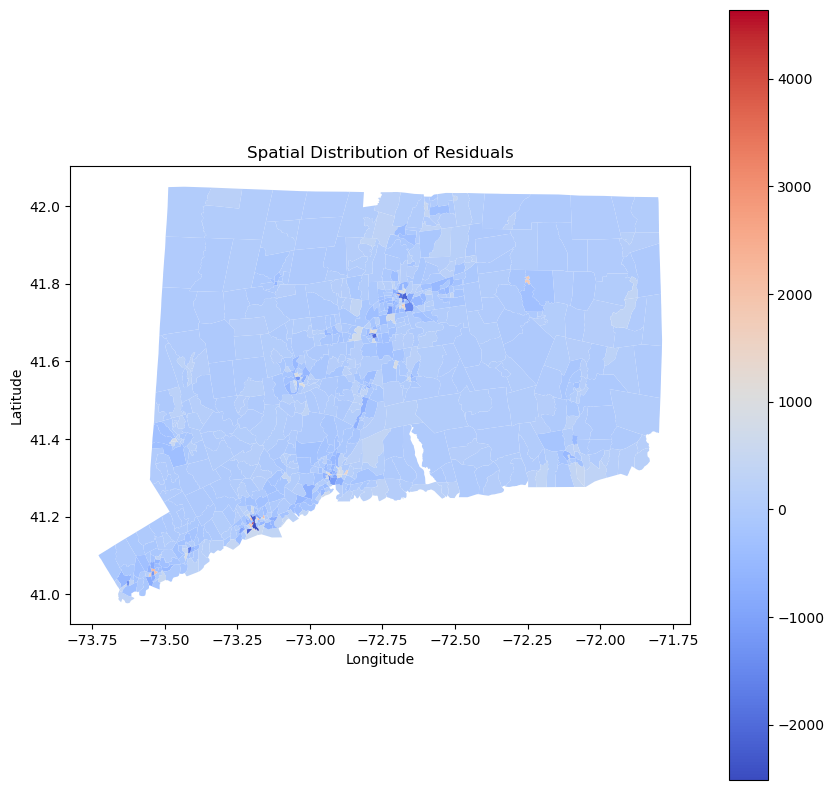

In [100]:
predictor = landcover_pct + ['spatial_lag_PopDens']

X_merged_gdf = merged_gdf[predictor].values
y_merged_gdf = merged_gdf['PopDensity'].values.reshape(-1, 1)

model = LinearRegression()
model.fit(X_merged_gdf, y_merged_gdf)

y_pred = model.predict(X_merged_gdf)
residuals = y_merged_gdf - y_pred

merged_gdf['residuals'] = residuals

fig, ax = plt.subplots(figsize=(10, 10))
merged_gdf.plot(column='residuals', cmap='coolwarm', legend=True, ax=ax)
plt.title('Spatial Distribution of Residuals')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [101]:
merged_gdf.drop(columns=['residuals'], inplace=True)

In [102]:
from linear_regression import RidgeRegression
merged_gdf.drop(columns=['spatial_lag_PopDens'], inplace=True)

In [103]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [104]:
# Spatially lagged endogenous regressors
odd_counties = ['NewLondonCounty', 'NewHavenCounty', 'LitchfieldCounty', 'TollandCounty']
even_counties = ['MiddlesexCounty', 'FairfieldCounty','HartfordCounty', 'WindhamCounty']

rmse = []

for i in range(4):

    train_1 = merged_gdf[(merged_gdf['County'] != odd_counties[i]) & (merged_gdf['County'] != even_counties[i])]
    test_1 = merged_gdf[(merged_gdf['County'] == odd_counties[i]) | (merged_gdf['County'] == even_counties[i])]

    train_1_w = Queen.from_dataframe(train_1)
    test_1_w = Queen.from_dataframe(test_1)

    train_1_w.transform = 'R'
    test_1_w.transform = 'R'

    train_1['spatial_lag_PopDens'] = lp.weights.lag_spatial(train_1_w, train_1['PopDensity'])
    test_1['spatial_lag_PopDens'] = lp.weights.lag_spatial(test_1_w, test_1['PopDensity'])
    
    y_train = np.array(train_1['PopDensity']).reshape((-1,1))
    x_train = np.array(train_1[predictor])

    y_test = np.array(test_1['PopDensity'])
    x_test = np.array(test_1[predictor])

    # IT WOULD BE GREAT IF WE CAN USE OUR OWN LINEAR REGRESSION.PY!
    # Fit linear regression model using scikit-learn 
    model = LinearRegression()
    model.fit(x_train, y_train)

    # Predict on test data
    y_pred_test = model.predict(x_test)

    # Calculate RMSE
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))

    rmse.append(test_rmse)


/tmp/ipykernel_205227/1594712926.py:12: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  train_1_w = Queen.from_dataframe(train_1)
/tmp/ipykernel_205227/1594712926.py:13: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  test_1_w = Queen.from_dataframe(test_1)
/home/manny/anaconda3/envs/ml-0451/lib/python3.11/site-packages/libpysal/weights/contiguity.py:347: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  W.__init__(self, neighbors, ids=ids, **kw)
/home/manny/.local/lib/python3.11/site-packages/geopandas/geodataframe.py:1525: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.py

In [105]:
rmse

[233.7932294798768, 564.1632428324364, 440.01616697335425, 292.7235949958683]

## Spatially lagged exogenous regressors

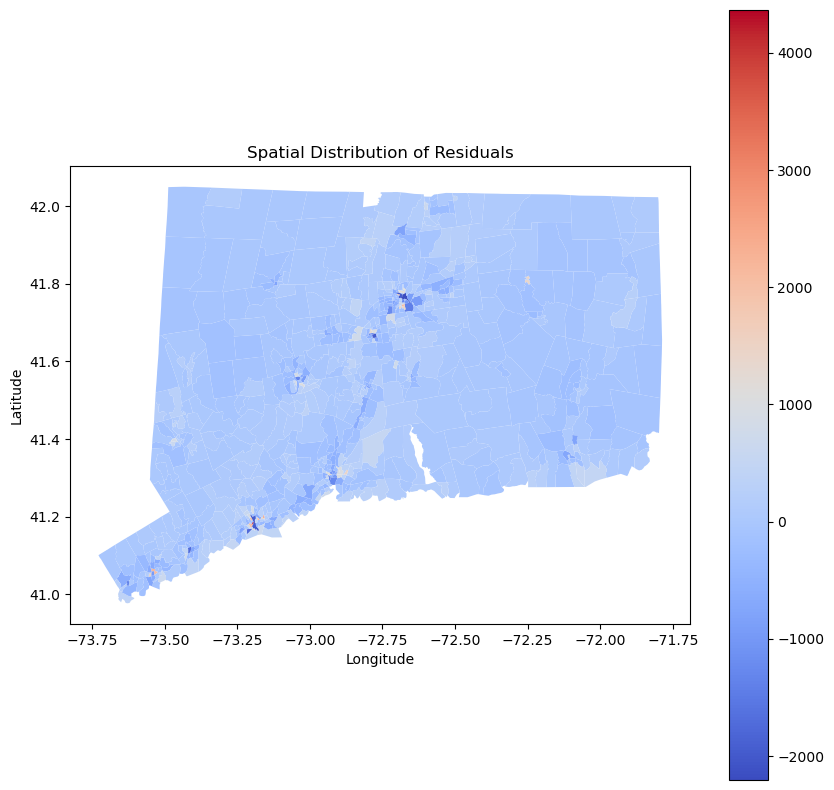

In [106]:
exo_predictor = landcover_pct + ['lag_2pct', 'lag_5pct', 'lag_11pct', 'lag_12pct', 'lag_8pct', 'lag_13pct', 'lag_14pct', 'lag_15pct', 'lag_20pct', 'lag_21pct'] 

for i in range(len(landcover_pct)):
        merged_gdf['lag_' + landcover_pct[i]] = lp.weights.lag_spatial(w, merged_gdf[landcover_pct[i]])

X_merged_gdf_exo = merged_gdf[exo_predictor].values
y_merged_gdf_exo = merged_gdf['PopDensity'].values.reshape(-1, 1)

model_exo = LinearRegression()
model_exo.fit(X_merged_gdf_exo, y_merged_gdf_exo)

y_pred_exo = model_exo.predict(X_merged_gdf_exo)
residuals_exo = y_merged_gdf_exo - y_pred_exo

merged_gdf['residuals_exo'] = residuals_exo

fig, ax = plt.subplots(figsize=(10, 10))
merged_gdf.plot(column='residuals_exo', cmap='coolwarm', legend=True, ax=ax)
plt.title('Spatial Distribution of Residuals')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()



In [111]:
# Spatially lagged exogenous regressors

rmse_exo = []

for i in range(4):

    train_1 = merged_gdf[(merged_gdf['County'] != odd_counties[i]) & (merged_gdf['County'] != even_counties[i])]
    test_1 = merged_gdf[(merged_gdf['County'] == odd_counties[i]) | (merged_gdf['County'] == even_counties[i])]

    train_1_w = Queen.from_dataframe(train_1)
    test_1_w = Queen.from_dataframe(test_1)

    train_1_w.transform = 'R'
    test_1_w.transform = 'R'

    for j in range(len(landcover_pct)):
        train_1['lag_' + landcover_pct[j]] = lp.weights.lag_spatial(train_1_w, train_1[landcover_pct[j]])
        test_1['lag_' + landcover_pct[j]] = lp.weights.lag_spatial(test_1_w, test_1[landcover_pct[j]])
    

    y_train = np.array(train_1['PopDensity']).reshape((-1,1))
    x_train = np.array(train_1[exo_predictor])

    y_test = np.array(test_1['PopDensity'])
    x_test = np.array(test_1[exo_predictor])

    # IT WOULD BE GREAT IF WE CAN USE OUR OWN LINEAR REGRESSION.PY!
    # Fit linear regression model using scikit-learn 
    model = LinearRegression()
    model.fit(x_train, y_train)

    # Predict on test data
    y_pred_test = model.predict(x_test)

    # Calculate RMSE
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))

    rmse_exo.append(test_rmse)


/tmp/ipykernel_205227/1383653996.py:10: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  train_1_w = Queen.from_dataframe(train_1)
/tmp/ipykernel_205227/1383653996.py:11: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  test_1_w = Queen.from_dataframe(test_1)
/home/manny/anaconda3/envs/ml-0451/lib/python3.11/site-packages/libpysal/weights/contiguity.py:347: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  W.__init__(self, neighbors, ids=ids, **kw)
/home/manny/.local/lib/python3.11/site-packages/geopandas/geodataframe.py:1525: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.py

In [112]:
rmse_exo

[259.0632499447656, 571.9490662359156, 475.44780270533465, 258.1606510672176]

. 

.

.

In [121]:
np.size(train_1_w)

1

## XXX Below this line records my attempt to harness ML_Lag but I was not successful XXX
-------------------------------------------------------------------

In [123]:
model1 = ML_Lag(y=y_train, x=x_train, w=train_1_w, name_y='PopDensity', name_x=landcover_pct, name_w='SpatialWeightsMatrix')
# the coefficients of the model
model1.betas

/home/manny/anaconda3/envs/ml-0451/lib/python3.11/site-packages/spreg/diagnostics.py:354: RuntimeWarning: invalid value encountered in sqrt
  se_result = np.sqrt(variance)
/home/manny/anaconda3/envs/ml-0451/lib/python3.11/site-packages/spreg/diagnostics.py:170: RuntimeWarning: invalid value encountered in sqrt
  ) / np.sqrt(variance)


ValueError: Length mismatch: Expected axis has 22 elements, new values have 12 elements

In [124]:
# output for the model
print(model1.summary)

NameError: name 'model1' is not defined

In [42]:
# SEE OUTPUT FOR GM_Lag
# Build full table of regression coefficients
# pd.DataFrame(
#     {
#         # Pull out regression coefficients and
#         # flatten as they are returned as Nx1 array
#         "Coeff.": model.betas.flatten(),
#         # Pull out and flatten standard errors
#         "Std. Error": model.std_err.flatten(),
#         # Pull out P-values from t-stat object
#         "P-Value": [i[1] for i in model.z_stat],
#     },
#     # Round to four decimals
# ).round(4)

/Users/yidexu/opt/anaconda3/envs/ml-0451/lib/python3.9/site-packages/geopandas/geodataframe.py:1525: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


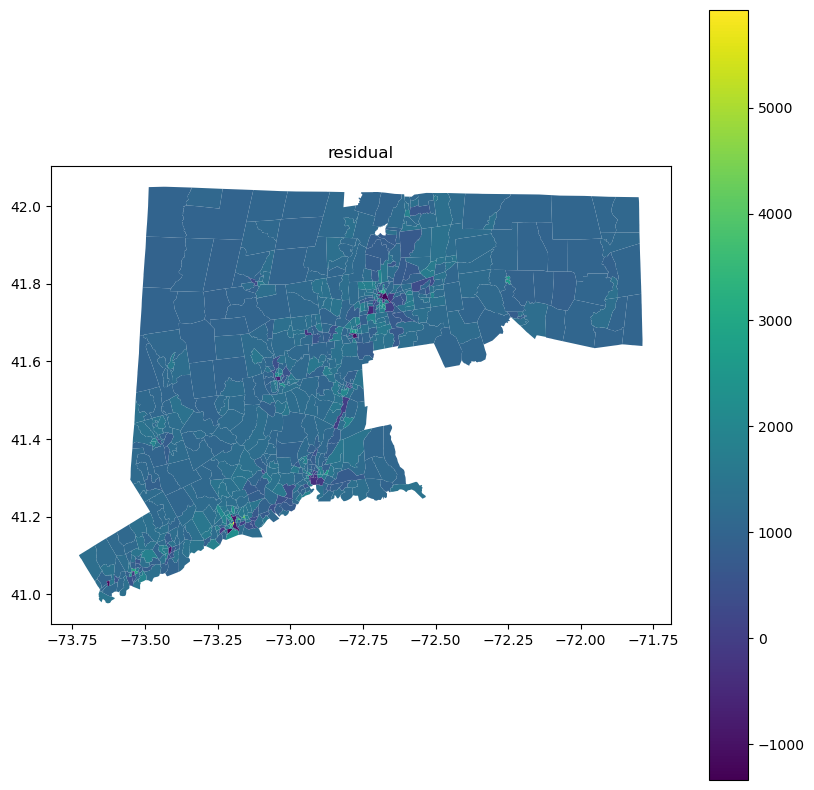

In [151]:
train_1['lag_pred'] = model.predy_e
train_1['y_hat_lag_pred'] = train_1['PopDensity'] - train_1['lag_pred']

# Plot the map
fig, ax = plt.subplots(figsize=(10, 10))
train_1.plot(column='y_hat_lag_pred', cmap='viridis', legend=True, ax=ax)
plt.title('residual')
plt.show()

In [144]:
model_error = ML_Error(y=y_train, x=x_train, w=train_1_w, name_y='PopDensity', name_x=landcover_pct, name_w='SpatialWeightsMatrix')

/Users/yidexu/opt/anaconda3/envs/ml-0451/lib/python3.9/site-packages/scipy/optimize/_minimize.py:913: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  warn("Method 'bounded' does not support relative tolerance in x; "
/Users/yidexu/opt/anaconda3/envs/ml-0451/lib/python3.9/site-packages/spreg/ml_error.py:528: RuntimeWarning: invalid value encountered in log
  nlsig2 = (n / 2.0) * np.log(sig2)


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/Users/yidexu/opt/anaconda3/envs/ml-0451/lib/python3.9/site-packages/spreg/diagnostics.py:354: RuntimeWarning: invalid value encountered in sqrt
  se_result = np.sqrt(variance)
/Users/yidexu/opt/anaconda3/envs/ml-0451/lib/python3.9/site-packages/spreg/diagnostics.py:170: RuntimeWarning: invalid value encountered in sqrt
  ) / np.sqrt(variance)


In [145]:
print(model_error.summary)

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: ML SPATIAL ERROR (METHOD = full)
---------------------------------------------------
Data set            :     unknown
Weights matrix      :SpatialWeightsMatrix
Dependent Variable  :  PopDensity                Number of Observations:         726
Mean dependent var  :    867.2255                Number of Variables   :          11
S.D. dependent var  :   1071.7093                Degrees of Freedom    :         715
Pseudo R-squared    :      0.7355
Log likelihood      :  -5159.2459
Sigma-square ML     : 392288.2249                Akaike info criterion :   10340.492
S.E of regression   :    626.3292                Schwarz criterion     :   10390.955

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT      1536.0

In [119]:
# estimate of spatial autoregressive coefficient
"{0:.6f}".format(model.rho) 

'-0.024751'

In [127]:
# Sum of squared residuals
"{0:.4f}".format(model.utu)

'1336430201.3650'

/var/folders/d5/f0qvkb_x4k1d4868jk4b1rzr0000gn/T/ipykernel_61603/3862628888.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  merged_gdf.centroid.plot(ax=ax, c='black')


<Axes: >

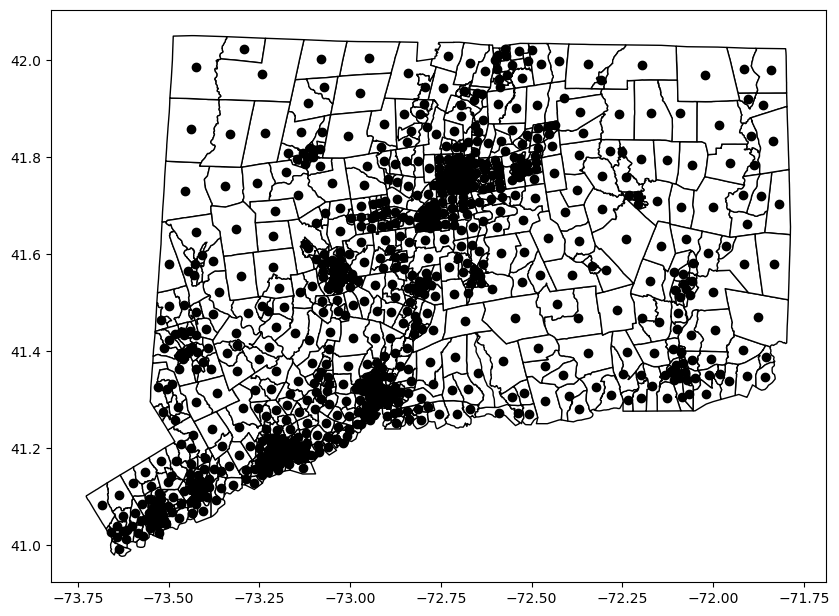

In [448]:
fig, ax = plt.subplots(figsize=(10,10))
merged_gdf.plot(ax=ax, **{'edgecolor':'black', 'facecolor':'white'})
merged_gdf.centroid.plot(ax=ax, c='black')

In [452]:
centroids = merged_gdf.geometry.centroid

# Extract longitude and latitude
longitude = centroids.x
latitude = centroids.y

g_coords = list(zip(longitude,latitude))


/var/folders/d5/f0qvkb_x4k1d4868jk4b1rzr0000gn/T/ipykernel_61603/777703877.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = merged_gdf.geometry.centroid
